In [1]:
import pandas as pd
import numpy as np
np.seterr(all="raise")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df1 = pd.read_parquet("out/2019-11-06-1d-train.parquet")
df2 = pd.read_parquet("out/2019-11-07-1d-train.parquet")
print(len(df1))
print(len(df2))
df = pd.concat((df1, df2))

i = df.direct_time < 0
assert i.sum() == 107
df = df[~i]

i = df.fft_time <= 0
assert i.sum() == 121
df = df[~i]

24500
14211


In [4]:
df["h_nelement"] = df["h.shape[0]"]# * df["h.shape[1]"]
df["x_nelement"] = df["x.shape[0]"]# * df["x.shape[1]"]
df["log2(fft_time/direct_time)"] = np.log2(df.fft_time / df.direct_time)
df["log2(fft_time)"] = np.log2(df.fft_time)
df["log2(direct_time)"] = np.log2(df.direct_time)
df["fft_time/direct_time"] = df.fft_time / df.direct_time
df.tail()

,fft_time,direct_time,mode,x.shape[0],h.shape[0],random_state,h_nelement,x_nelement,log2(fft_time/direct_time),log2(fft_time),log2(direct_time),fft_time/direct_time
14206,0.000377,0.002556,same,6685,2282,1054206,2282,6685,-2.762174,-11.374291,-8.612117,0.147402
14207,0.000127,0.000021,same,469,28,1054207,28,469,2.563429,-12.944718,-15.508147,5.911111
14208,0.000128,0.000335,same,53,570,1054208,570,53,-1.382837,-12.928538,-11.545701,0.383464
14209,0.000118,0.000017,same,159,51,1054209,51,159,2.822002,-13.048715,-15.870717,7.071429
14210,0.000109,0.000013,same,31,31,1054210,31,31,3.057844,-13.160796,-16.218640,8.327273


In [5]:
df.direct_time.max()

32.231529235839844

In [6]:
df.fft_time.max()

0.004791975021362305

In [7]:
df.direct_time.max()

32.231529235839844

In [8]:
(df["mode"] == "same").sum() / len(df)

0.7468232726138815

In [9]:
for k in ["x_nelement", "h_nelement"]:
    df[k + "_binned"] = np.round(df[k], decimals=-2)

# Visualize ratio

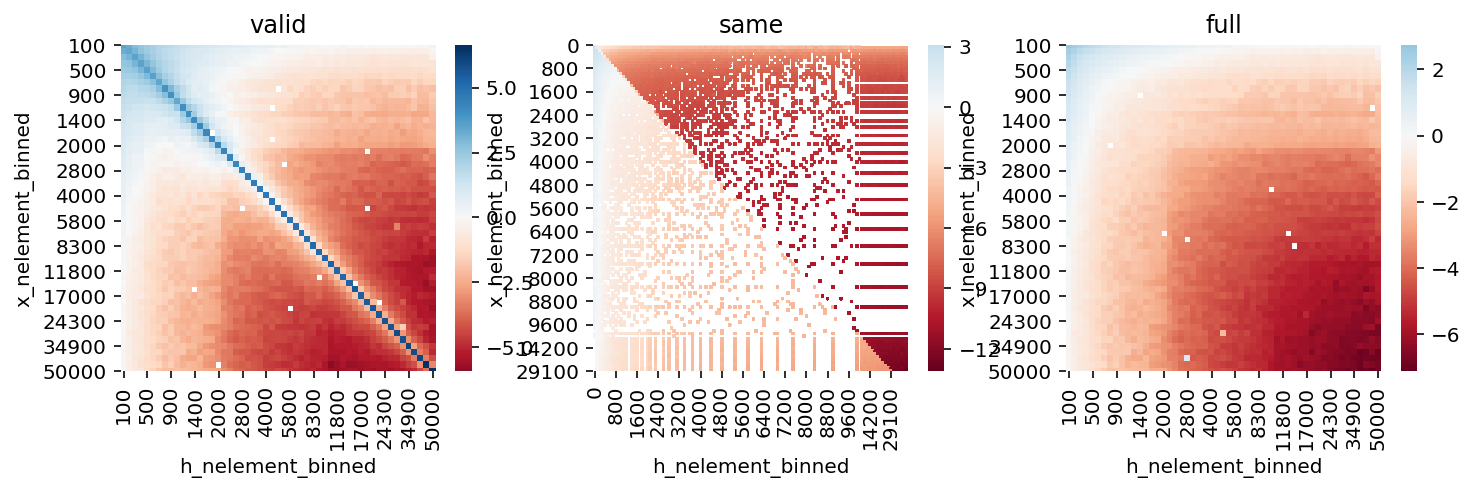

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

w = 3
fig, axs = plt.subplots(ncols=3, figsize=(4 * w, w))
for ax, mode in zip(axs, ["valid", "same", "full"]):
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    index = "x_nelement"
    columns = "h_nelement"
    if "x_nelement_binned" in df:
        index +="_binned"
        columns += "_binned"
    show = df[df["mode"] == mode].pivot_table(
        index=index,
        columns=columns,
        values="log2(fft_time/direct_time)",
    )
    ax = sns.heatmap(
        show,
        center=0,
        ax=ax,
        cmap="RdBu",
    )
    _ = ax.set_title(mode)

* Blue: direct faster
* Red: FFT faster

# Find big-O constant

In [11]:
import sys
sys.path.append("..")
from common import _fftconv_faster, _prod

In [12]:
from scipy.optimize import curve_fit

def log_time(shapes, O, mode):
# def _fftconv_faster(shapes, O, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    times = []
    for shape in shapes:
        x_shape = np.array([shape[0]])
        h_shape = np.array([shape[1]])
        assert len(shape) == 2
        assert len(x_shape) == len(h_shape) == 1
        fft_time, direct_time = _fftconv_faster(
            x_shape, h_shape, mode,
        )
        times.append([fft_time, direct_time])
    times = np.asarray(times)
    fft_time = times[:, 0]
    direct_time = times[:, 1]
    diff = O * fft_time / direct_time
    
    power = np.log2(abs(diff))
    sign = np.sign(diff)
    return sign * power

def get_constant(df, mode):
    """
    Inputs
    ------
    df : DataFrame with columns x.shape[0], x.shape[1], h.shape[0], h.shape[1] and log2(fft_time/direct_time)
    
    Returns
    -------
    popt : float
        The constant such that constant * fft_time < direct_time
    pstd : float
        The (estimated) standard deviation of popt
    """
    shapes = df[["x.shape[0]", "h.shape[0]"]].values
    times = df["log2(fft_time/direct_time)"].values
    log_time_w_mode = partial(log_time, mode=mode)

#     p0s = {"full": 9e3, "same": 34e3, "valid": 66e3}
#     kwargs = {"p0": 2 * p0s[mode]}
#     kwargs = {"p0": 20e3}
    kwargs = {}
    popt, pcov = curve_fit(log_time_w_mode, shapes, times, **kwargs)
    O = popt.item()
    times_hat = log_time_w_mode(shapes, O)
    return O, np.sqrt(pcov).item(), (times_hat, times)

In [13]:
bigOs = []

In [14]:
from toolz import partial

for mode in ["valid", "full"]:
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    fit = df[idx].copy()
    O, std, times = get_constant(fit, mode)
    y_hat, y = times
    fit["predicted_ratio"] = y_hat
    print(mode, O, std)
    bigOs.append({"mode": mode, "constant": O, "std": std})

valid 14.336458082971573 0.13344469622829414
full 11.548068597910962 0.08081081901547015


In [15]:
mode = "same"
same = df[df["mode"] == mode].copy()
print(same.columns)

np_conv = same.h_nelement <= same.x_nelement
sp_conv = ~np_conv
for condition, idx in {"np_conv": np_conv, "sp_conv": sp_conv}.items():
    fit = same[idx].copy()
    O, std, times = get_constant(fit, mode)
    y_hat, y = times
    fit["predicted_ratio"] = y_hat
    print(mode, condition, O, std)
    bigOs.append({"mode": mode, "constant": O, "std": std, "cond": condition})

Index(['fft_time', 'direct_time', 'mode', 'x.shape[0]', 'h.shape[0]',
       'random_state', 'h_nelement', 'x_nelement',
       'log2(fft_time/direct_time)', 'log2(fft_time)', 'log2(direct_time)',
       'fft_time/direct_time', 'x_nelement_binned', 'h_nelement_binned'],
      dtype='object')
same np_conv 15.747428643244357 0.08888964067251177
same sp_conv 0.7336707847734739 0.005842600449943442


In [16]:
constants = pd.DataFrame(bigOs)
constants["ndim"] = 1

In [17]:
constants

,mode,constant,std,cond,ndim
0,valid,14.336458,0.133445,NaN,1
1,full,11.548069,0.080811,NaN,1
2,same,15.747429,0.088890,np_conv,1
3,same,0.733671,0.005843,sp_conv,1


In [18]:
constants["std"] / constants["constant"]

0    0.009308
1    0.006998
2    0.005645
3    0.007964
dtype: float64

In [19]:
constants.to_csv("constants.csv", index=False)
